In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from wide_resnet import WideResNet
from MyModel import MyModel
from keras.utils import to_categorical
from keras.models import Sequential
import Augmentor




os.environ["CUDA_VISIBLE_DEVICES"]="1"
# load model and weights
img_size = 224
#model64 = MyModel(img_size)()
#model64.load_weights(os.path.join("models", "WRN_16_8.h5"))

#img_size32 = 32
#model32 = WideResNet(img_size32, depth=16, k=8)()
#model32.load_weights(os.path.join("../../dataset/checkpoints", "model32.hdf5"))


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
db = "wiki"
data = scipy.io.loadmat(os.path.join("../../dataset/", "{}32.mat".format(db)))
test_images = data["image"]
test_genders = data["gender"][0]
test_ages = data["age"][0]

cols, rows = 4, 3
img_num = cols * rows
path_root = "data/{}_crop/".format(db)
img_ids = np.random.choice(len(test_ages), img_num)
sub_test_images = test_images[img_ids,:,:,:]

# predict
results = model32.predict(sub_test_images)
predicted_genders = results[0]
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages = results[1].dot(ages).flatten()

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(sub_test_images[i,:,:,:], cv2.COLOR_BGR2RGB))
    plt.title("{}, {}".format(int(predicted_ages[i]),
                              "F" if predicted_genders[i][0]>0.5 else "M"))
    plt.axis('off')
plt.savefig("result.png")

In [ ]:
from os import listdir
from os.path import isfile, join
import face_recognition
mypath='test/'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
#images32 = np.empty(len(onlyfiles), dtype=object)
#faces32 = np.empty((len(onlyfiles), img_size32, img_size32, 3))
images64 = np.empty(len(onlyfiles), dtype=object)
faces64 = np.empty((len(onlyfiles), 224, 224, 3))
for n in range(0, len(onlyfiles)):
   # images32[n] = cv2.imread( join(mypath,onlyfiles[n]))
    #images32[n] = cv2.cvtColor(images32[n],cv2.COLOR_BGR2RGB)
    #faces32[n, : , : , :] = cv2.resize(images32[n][35:-35,35:-35,:], (img_size32, img_size32))
    image = face_recognition.load_image_file(join(mypath,onlyfiles[n]))
    face_locations = face_recognition.face_locations(image)[0]
    #print(face_locations)
    #print(face_locations[0],face_locations[2])
    #print(face_locations[3],face_locations[1])
    #print(image.shape)
    images64[n] = image[face_locations[0]:face_locations[2],face_locations[3]:face_locations[1],:]
    faces64[n, : , : , :] = cv2.resize(images64[n], (224, 224))
    
#results32 = model32.predict(faces32)
results64 = model64.predict(faces64)
#predicted_genders32 = results32[0]
#predicted_genders64 = results64[0]
ages = np.arange(0, 101).reshape(101, 1)
#predicted_ages32 = results32[1].dot(ages).flatten()
predicted_ages64 = results64.dot(ages).flatten()

for n in range(len(onlyfiles)):
    plt.figure()
   # plt.imshow(cv2.resize(images32[n], (img_size64, img_size64)))
    #print("Age " +onlyfiles[n]+ " (32x32): ", int(predicted_ages32[n]))
    #print("Gender " +onlyfiles[n]+ " (32x32): ", "F" if predicted_genders32[n][0] > 0.5 else "M")
    plt.figure()
    plt.imshow(images64[n])
    print("Age " +onlyfiles[n]+ " (64x64): ", predicted_ages64[n])
    #print("Gender " +onlyfiles[n]+ " (64x64): ", "F" if predicted_genders64[n][0] > 0.5 else "M")

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def generate_data_generator(generator):
    for x_batch,y_batch in generator:
            ages = np.arange(0, 101).reshape(101, 1)
            round_age = [int(pred.dot(ages).flatten()) for pred in y_batch]
            yield x_batch, [y_batch, np.array(round_age)]

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

val_generator = train_datagen.flow_from_directory(
    '../../dataset/wiki_crop/new_database/',
    target_size=(img_size, img_size),
    class_mode='categorical',
    subset='validation',
    shuffle=True)

In [ ]:

def x_difference(val_generator, X):
    print(len(val_generator.classes))
    predictions = model64.predict_generator(generate_data_generator(val_generator),steps=int(6769 / 16))
    print("Done Prediction...")
    ages = np.arange(0, 101).reshape(101, 1)
    predicted_age = predictions[0].dot(ages).flatten()
    predicted_age_regressed = predictions[1]
    
    counter = 0
    counter2 = 0
    counter3 = 0
    #print(predicted_age_regressed)
    
    avg = [(predicted_age[i] + predicted_age_regressed[i])/2 for i in range(len(val_generator.classes))]
    
    #print(avg)
    summ = 0
    for i in range(len(val_generator.classes)):
        real_label = val_generator.classes[i]
        #print(real_label)
        #print(avg[i])
        if abs(real_label - predicted_age[i]) <= X:
            counter += 1
        if abs(real_label - avg[i]) <= X:
            counter2 += 1
        if abs(real_label - predicted_age_regressed[i]) <= X:
            counter3 += 1
        
        summ += abs(real_label - avg[i])
    #return counter / len(val_generator.classes),counter2 / len(val_generator.classes), counter3 / len(val_generator.classes)
    return summ / len(val_generator.classes)
c1 = x_difference(val_generator,10)

print(c1)
#print(c2)
#print(c3)


In [ ]:
model64.save_weights(os.path.join("models", "Tentativa.h5"), overwrite=True)

In [2]:
from os import listdir
from os.path import isfile, join

path_fg_net = "../../dataset/FGNET/images/"

images = [ f for f in listdir(path_fg_net) if isfile(join(path_fg_net,f)) ]

images = sorted(images)

x_batch = [cv2.resize(cv2.imread(path_fg_net+img),(224,224)) for img in images]

In [3]:
y_true = [int(name.split('A')[1][:2]) for name in images]

In [4]:
import random

c = list(zip(x_batch, y_true))

random.shuffle(c)

x_batch, y_true = zip(*c)

x_batch = np.array(x_batch)


percentage = 0.2
x_data = (x_batch[:int(len(x_batch)*(1-percentage))],x_batch[int(len(x_batch)*(1-percentage)):])
y_data = (y_true[:int(len(y_true)*(1-percentage))],y_true[int(len(y_true)*(1-percentage)):])

x_train, y_train = x_data[0], np.array(y_data[0])
x_val, y_val = x_data[1], np.array(y_data[1])

print(x_batch.shape)
print(y_val[2])

(2004, 224, 224, 3)
48


In [5]:
p = Augmentor.Pipeline()
p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)

In [6]:
#train and val

y_train2 = to_categorical(y_train, 101).astype('float32')
y_val2 = to_categorical(y_val, 101).astype('float32')

y_train = y_train.reshape(len(y_train),1)
y_val = y_val.reshape(len(y_val),1)

y_train = np.array(y_train).reshape(-1)
y_val = np.array(y_val).reshape(-1)
#print(y_train2.shape)
#print(x_val.shape)

print(y_train2.shape)

(1603, 101)


In [10]:
###
from MyModel import MyModel
from keras.optimizers import SGD, Adam

model = MyModel(224,trainable=False)()
sgd = Adam(lr=0.0001)

#getBatches

batch_size = 16

def get_batch(x_train, y_train, y_train2):
    while True:
        for batches in range(len(x_train) // batch_size):
            x_batch = x_train[batches*batch_size:min(len(x_train),(batches+1)*batch_size)]
            y_batch = y_train[batches*batch_size:min(len(y_train),(batches+1)*batch_size)]
            y_batch2 = y_train2[batches*batch_size:min(len(y_train2),(batches+1)*batch_size)]
            yield x_batch, [y_batch2,y_batch]


model.compile(optimizer=sgd, loss=["categorical_crossentropy","MSE"], loss_weights=[0.5,1],
              metrics=['accuracy'])

model.fit_generator(get_batch(x_train, y_train, y_train2),
                    steps_per_epoch=len(x_train) // batch_size, epochs=50, validation_data = (x_val, [y_val2,y_val]))

Epoch 1/50
100/100 [==============================] - 9s 90ms/step - loss: 220.4667 - pred_age_loss: 14.9102 - regress_age_loss: 207.0211 - pred_age_acc: 0.0431 - regress_age_acc: 0.0350 - val_loss: 207.9409 - val_pred_age_loss: 15.1389 - val_regress_age_loss: 194.6097 - val_pred_age_acc: 0.0524 - val_regress_age_acc: 0.0324
Epoch 2/50
100/100 [==============================] - 9s 90ms/step - loss: 160.6781 - pred_age_loss: 14.6706 - regress_age_loss: 147.6859 - pred_age_acc: 0.0606 - regress_age_acc: 0.0331 - val_loss: 176.8243 - val_pred_age_loss: 14.5939 - val_regress_age_loss: 163.9572 - val_pred_age_acc: 0.0698 - val_regress_age_acc: 0.0274
Epoch 3/50
100/100 [==============================] - 8s 79ms/step - loss: 136.7875 - pred_age_loss: 14.5292 - regress_age_loss: 124.0130 - pred_age_acc: 0.0762 - regress_age_acc: 0.0481 - val_loss: 154.5942 - val_pred_age_loss: 14.3801 - val_regress_age_loss: 141.9484 - val_pred_age_acc: 0.0698 - val_regress_age_acc: 0.0474
Epoch 4/50
100/100 

100/100 [==============================] - 8s 77ms/step - loss: 49.2202 - pred_age_loss: 1.3802 - regress_age_loss: 44.0664 - pred_age_acc: 0.6231 - regress_age_acc: 0.0706 - val_loss: 63.4061 - val_pred_age_loss: 2.7796 - val_regress_age_loss: 57.5659 - val_pred_age_acc: 0.4040 - val_regress_age_acc: 0.0773
Epoch 27/50
100/100 [==============================] - 9s 91ms/step - loss: 48.2662 - pred_age_loss: 1.0204 - regress_age_loss: 43.3188 - pred_age_acc: 0.7144 - regress_age_acc: 0.0738 - val_loss: 62.5205 - val_pred_age_loss: 2.6614 - val_regress_age_loss: 56.7665 - val_pred_age_acc: 0.4464 - val_regress_age_acc: 0.0748
Epoch 28/50
100/100 [==============================] - 8s 79ms/step - loss: 47.3946 - pred_age_loss: 0.7485 - regress_age_loss: 42.6110 - pred_age_acc: 0.7887 - regress_age_acc: 0.0725 - val_loss: 61.6285 - val_pred_age_loss: 2.4446 - val_regress_age_loss: 56.0113 - val_pred_age_acc: 0.5262 - val_regress_age_acc: 0.0698
Epoch 29/50
100/100 [=========================

In [11]:
y_pred = model.predict(np.array(x_val))

In [13]:
ages = np.arange(0, 101).reshape(101, 1)
predicted_age = y_pred[0].dot(ages).flatten()
predicted_age_regressed = y_pred[1]

avg = [(predicted_age[i] + predicted_age_regressed[i])/2 for i in range(len(x_val))]

In [14]:
summ = 0
for i in range(len(x_val)):
    summ += abs(y_val[i] - avg[i])

print(summ/len(x_val))

[3.0786748]


In [15]:
model.save('models/state_art.h5')

AVG rockewell49.jpg (64x64):  [33.288338]
Class rockewell49.jpg (64x64):  33.79064308494719
Regress rockewell49.jpg (64x64):  [32.78603]
AVG streep68.jpg (64x64):  [39.689728]
Class streep68.jpg (64x64):  40.95294130402741
Regress streep68.jpg (64x64):  [38.42651]
AVG miley25.jpg (64x64):  [20.629738]
Class miley25.jpg (64x64):  18.143813436002464
Regress miley25.jpg (64x64):  [23.115664]
AVG baby.jpg (64x64):  [-3.7558362]
Class baby.jpg (64x64):  0.010260981653010015
Regress baby.jpg (64x64):  [-7.5219336]
AVG katy.jpg (64x64):  [25.836311]
Class katy.jpg (64x64):  24.321733628703086
Regress katy.jpg (64x64):  [27.350887]
AVG tom.jpg (64x64):  [29.029022]
Class tom.jpg (64x64):  29.870344865778748
Regress tom.jpg (64x64):  [28.187702]
AVG ronaldo33.jpg (64x64):  [27.104877]
Class ronaldo33.jpg (64x64):  21.90153944313486
Regress ronaldo33.jpg (64x64):  [32.308216]
AVG may61.jpg (64x64):  [33.701412]
Class may61.jpg (64x64):  40.73830328801039
Regress may61.jpg (64x64):  [26.664518]
A

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

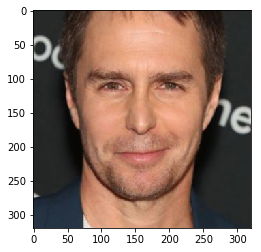

<Figure size 432x288 with 0 Axes>

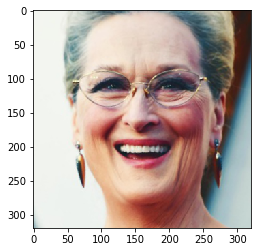

<Figure size 432x288 with 0 Axes>

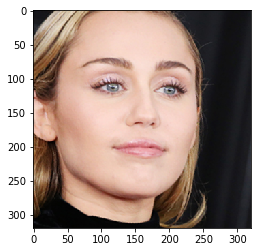

<Figure size 432x288 with 0 Axes>

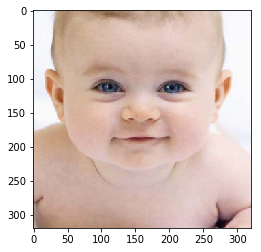

<Figure size 432x288 with 0 Axes>

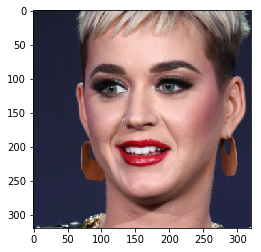

<Figure size 432x288 with 0 Axes>

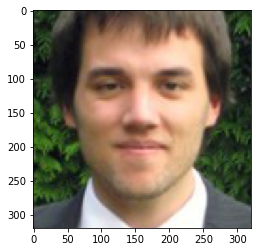

<Figure size 432x288 with 0 Axes>

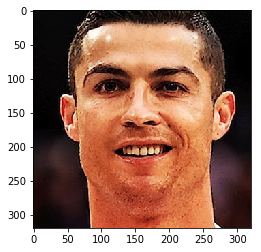

<Figure size 432x288 with 0 Axes>

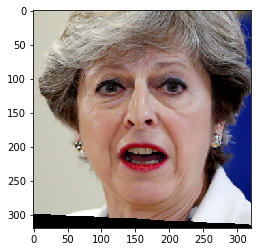

<Figure size 432x288 with 0 Axes>

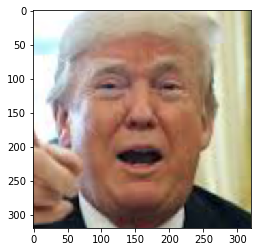

<Figure size 432x288 with 0 Axes>

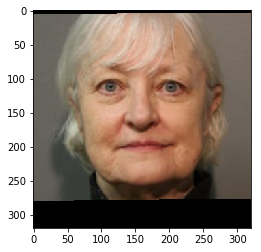

<Figure size 432x288 with 0 Axes>

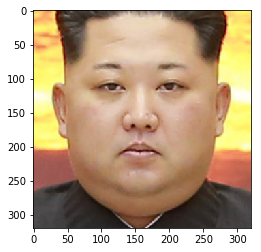

<Figure size 432x288 with 0 Axes>

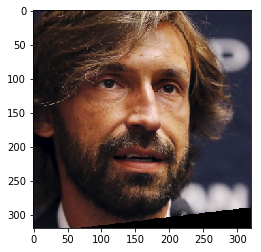

<Figure size 432x288 with 0 Axes>

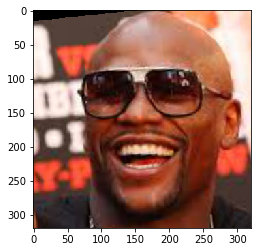

<Figure size 432x288 with 0 Axes>

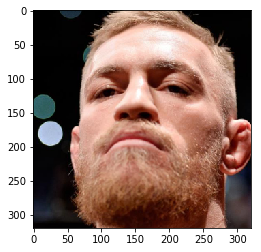

<Figure size 432x288 with 0 Axes>

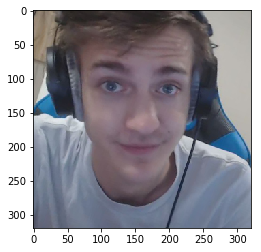

<Figure size 432x288 with 0 Axes>

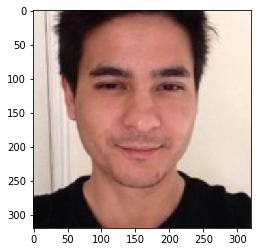

<Figure size 432x288 with 0 Axes>

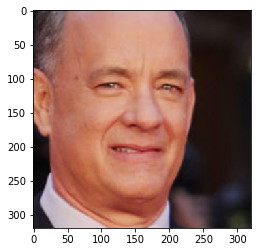

<Figure size 432x288 with 0 Axes>

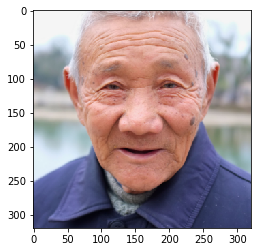

In [25]:
import dlib

detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor("predictor/shape_predictor_5_face_landmarks.dat")

mypath='test/'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
#images32 = np.empty(len(onlyfiles), dtype=object)
#faces32 = np.empty((len(onlyfiles), img_size32, img_size32, 3))
images64 = np.empty(len(onlyfiles), dtype=object)
faces64 = np.empty((len(onlyfiles), 224, 224, 3))
for n in range(0, len(onlyfiles)):
   # images32[n] = cv2.imread( join(mypath,onlyfiles[n]))
    #images32[n] = cv2.cvtColor(images32[n],cv2.COLOR_BGR2RGB)
    #faces32[n, : , : , :] = cv2.resize(images32[n][35:-35,35:-35,:], (img_size32, img_size32))
    image = face_recognition.load_image_file(join(mypath,onlyfiles[n]))
    
    dets = detector(image, 1)
    
    if len(dets) == 0:
        continue
    
    faces = dlib.full_object_detections()
    for detection in dets:
        faces.append(sp(image, detection))
    
    images = dlib.get_face_chips(image, faces, size=320, padding=0.5)
    
    images64[n] = images[0]
    
    
    
    #print(face_locations)
    #print(face_locations[0],face_locations[2])
    #print(face_locations[3],face_locations[1])
    #print(image.shape)
    #images64[n] = image[face_locations[0]:face_locations[2],face_locations[3]:face_locations[1],:]
    faces64[n, : , : , :] = cv2.resize(images64[n], (224, 224))
    
#results32 = model32.predict(faces32)
y_pred = model.predict(faces64)

ages = np.arange(0, 101).reshape(101, 1)
predicted_age = y_pred[0].dot(ages).flatten()
predicted_age_regressed = y_pred[1]

avg = [(predicted_age[i] + predicted_age_regressed[i])/2 for i in range(len(onlyfiles))]

for n in range(len(onlyfiles)):
    plt.figure()
   # plt.imshow(cv2.resize(images32[n], (img_size64, img_size64)))
    #print("Age " +onlyfiles[n]+ " (32x32): ", int(predicted_ages32[n]))
    #print("Gender " +onlyfiles[n]+ " (32x32): ", "F" if predicted_genders32[n][0] > 0.5 else "M")
    plt.figure()
    plt.imshow(images64[n])
    print("AVG " +onlyfiles[n]+ " (64x64): ", avg[n])
    print("Class " +onlyfiles[n]+ " (64x64): ", predicted_age[n])
    print("Regress " +onlyfiles[n]+ " (64x64): ", predicted_age_regressed[n])
    #print("Gender " +onlyfiles[n]+ " (64x64): ", "F" if predicted_genders64[n][0] > 0.5 else "M")